# Trading Strategies (b)

In [12]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import warnings

## Linear OLS Regression

# Linear OLS Regression for Market Movement Prediction
This section demonstrates how linear Ordinary Least Squares (OLS) regression can be applied to predict the direction of market movements using historical log returns. We focus on using two features derived from these log returns: lag_1 and lag_2.

The underlying hypothesis is that historical log returns can be indicative of future market trends, adhering to concepts like "mean reversion" and "momentum" or "trend". Log returns, unlike raw prices, are generally stationary, making them suitable for statistical analysis and machine learning algorithms.


We start by importing and preparing our dataset, focusing on the daily historical log returns for the EUR/USD exchange rate. These log returns will serve as the basis for our features and labels in the predictive model.


In [13]:
raw = pd.read_csv('tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True).dropna()

In [14]:
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

	EUR=	returns	direction
Date			
2010-01-05	1.4368	-0.002988	-1
2010-01-06	1.4412	0.003058	1
2010-01-07	1.4318	-0.006544	-1
2010-01-08	1.4412	0.006544	1
2010-01-11	1.4513	0.006984	

In [15]:
symbol = 'EUR='

In [16]:
data = pd.DataFrame(raw[symbol])

In [17]:
data['returns'] = np.log(data / data.shift(1))

In [18]:
data.dropna(inplace=True)

In [19]:
data['direction'] = np.sign(data['returns']).astype(int)

In [20]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


This code snippet prepares our data by calculating the log returns for the EUR/USD exchange rate and determining the direction of these returns (-1 for a decrease, 1 for an increase).

Visualizing the Returns
To better understand the distribution of returns, let's visualize it with a histogram.

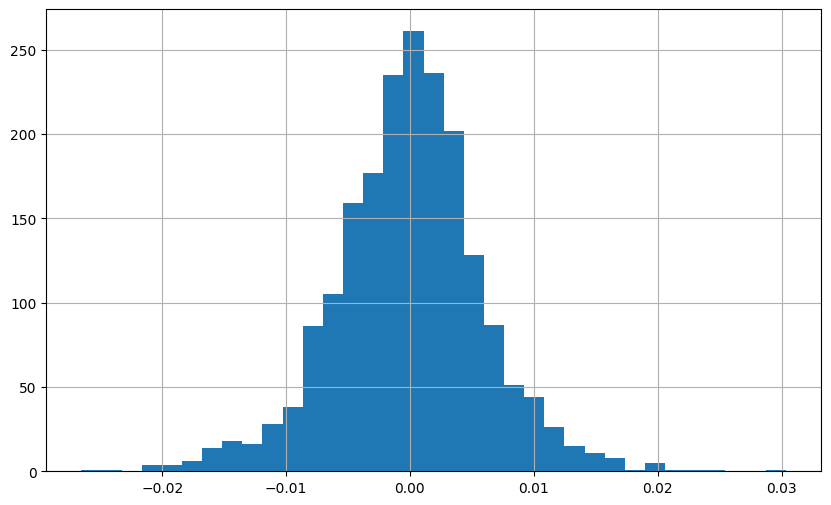

In [21]:
data['returns'].hist(bins=35, figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_01.png')


The histogram you are referring to (generated by the code snippet in [11]: data['returns'].hist(bins=35, figsize=(10, 6));) is likely visualizing the distribution of log returns of the EUR/USD exchange rate. Each bar in the histogram represents the frequency of log return values falling within a specific range. Here is what the histogram tells us:

Central Tendency: The histogram is centered around zero, which is typical for financial log returns. This suggests that there are many days where the return is close to zero, neither significantly up nor down.

Symmetry: The shape of the histogram appears symmetrical, suggesting that positive and negative returns occur with similar frequencies.

Volatility: The spread of the histogram indicates the volatility of the returns. A wider spread would mean higher volatility, while a narrower spread indicates lower volatility. In this case, the returns are mostly clustered around the center, suggesting moderate volatility.

Outliers: There do not appear to be significant outliers on either side, which would be indicated by long tails in the histogram. This suggests that extremely large or small returns are not common for this dataset.

Distribution: The overall shape of the histogram looks approximately like a normal distribution, which is a common pattern for financial time series data when market conditions are stable

In [22]:
lags = 2

In [23]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [24]:
create_lags(data)

This code snippet prepares our data by calculating the log returns for the EUR/USD exchange rate and determining the direction of these returns (-1 for a decrease, 1 for an increase).

In [25]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [26]:
data.dropna(inplace=True)

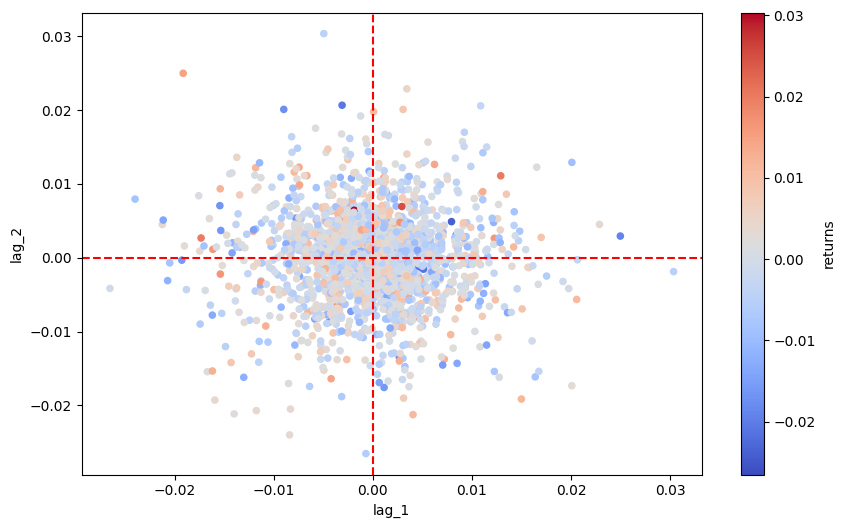

In [27]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns', 
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');
# plt.savefig('../../images/ch15/strat_ml_02.png');

### Regression

With the data set completed, linear OLS regression can be applied to learn about any potential (linear) relationships, to predict market movement based on the features, and to backtest a trading strategy based on the predictions. Two basic approaches are available: using the log returns or only the direction data as the dependent variable during the regression. In any case, predictions are real-valued and therefore transformed to either +1 or -1 to only work with the direction of the prediction

In [28]:
from sklearn.linear_model import LinearRegression  

In [29]:
model = LinearRegression()  

In [30]:
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])  

In [31]:
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])  

In [32]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-07,-0.000202,-0.004063
2010-01-08,0.000046,0.043384
2010-01-11,-0.000310,-0.019115
2010-01-12,-0.000143,-0.042655
2010-01-13,0.000007,0.005976


Real-valued predictions are transformed to directional values

In [33]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(
            data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)  

In [34]:
data['pos_ols_1'].value_counts()  

pos_ols_1
-1    1605
 1     364
Name: count, dtype: int64

In [35]:
data['pos_ols_2'].value_counts()  

pos_ols_2
 1    1231
-1     738
Name: count, dtype: int64

In [36]:
(data['pos_ols_1'].diff() != 0).sum()  

701

In [37]:
(data['pos_ols_2'].diff() != 0).sum()  

789

In [38]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [39]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [40]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.807938
strat_ols_1    1.345052
strat_ols_2    1.418594
dtype: float64

In [41]:
(data['direction'] == data['pos_ols_1']).value_counts()  

True     989
False    980
Name: count, dtype: int64

In [42]:
(data['direction'] == data['pos_ols_2']).value_counts()  

True     1023
False     946
Name: count, dtype: int64

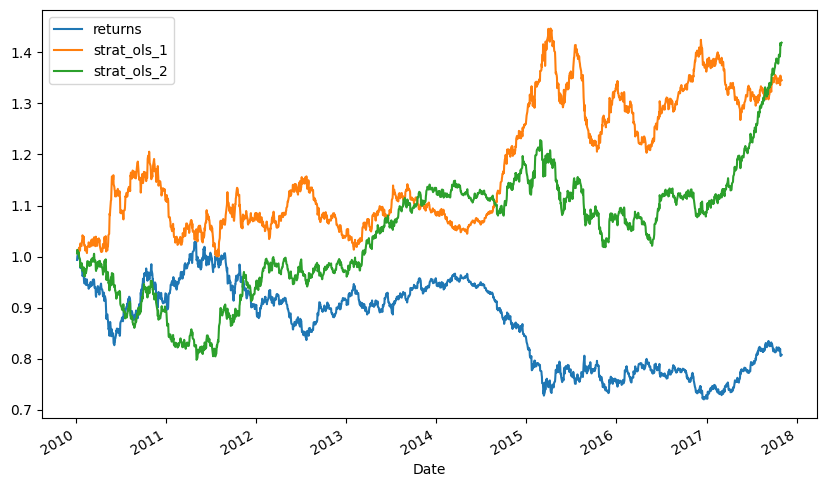

In [43]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_03.png');

Equipped with the directional prediction, vectorized backtesting can be applied to judge the performance of the resulting trading strategies. At this stage, the analysis is based on a number of simplifying assumptions, such as “zero transaction costs” and the usage of the same data set for both training and testing. Under these assumptions, however, both regression-based strategies outperform the benchmark passive investment, while only the strategy trained on the direction of the market shows a positive overall performance

## Clustering

In [44]:
from sklearn.cluster import KMeans

In [45]:
model = KMeans(n_clusters=2, random_state=0)  #  <1>

In [46]:
model.fit(data[cols])

KMeans(n_clusters=2, random_state=0)

In [47]:
data['pos_clus'] = model.predict(data[cols])

In [48]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)  

In [49]:
data['pos_clus'].values

array([ 1, -1,  1, ..., -1,  1,  1])

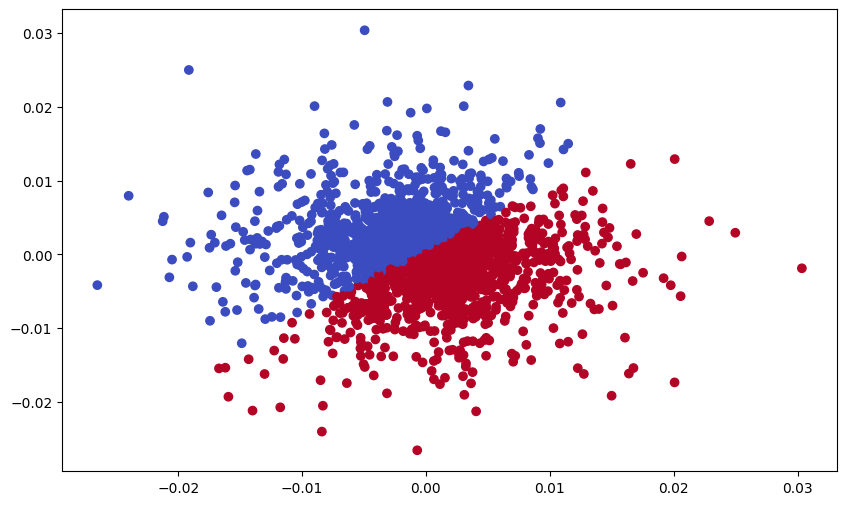

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],
            c=data['pos_clus'], cmap='coolwarm');
# plt.savefig('../../images/ch15/strat_ml_04.png');

In [51]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [52]:
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       0.807938
strat_clus    0.764502
dtype: float64

In [53]:
(data['direction'] == data['pos_clus']).value_counts()

False    1005
True      964
Name: count, dtype: int64

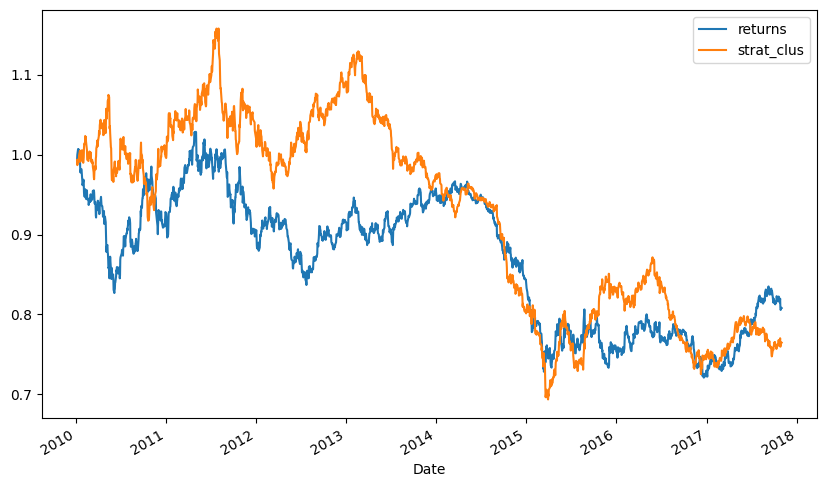

In [54]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_05.png');

## Frequency Approach

In [55]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

In [56]:
create_bins(data)

In [57]:
data[cols_bin + ['direction']].head()  

,lag_1_bin,lag_2_bin,direction
Date,,,
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1
2010-01-13,0,1,1


In [58]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()  

lag_1_bin  lag_2_bin  direction
0          0          -1           221
                       0             4
                       1           236
           1          -1           240
                       1           268
1          0          -1           250
                       0             1
                       1           258
           1          -1           259
                       0             4
                       1           228
dtype: int64

In [59]:
res = grouped['direction'].size().unstack(fill_value=0)  

In [60]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]  

In [61]:
res.style.apply(highlight_max, axis=1)  

In [62]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)  

In [63]:
(data['direction'] == data['pos_freq']).value_counts()

True     1021
False     948
Name: count, dtype: int64

In [64]:
data['strat_freq'] = data['pos_freq'] * data['returns']

In [65]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.807938
strat_freq    1.087601
dtype: float64

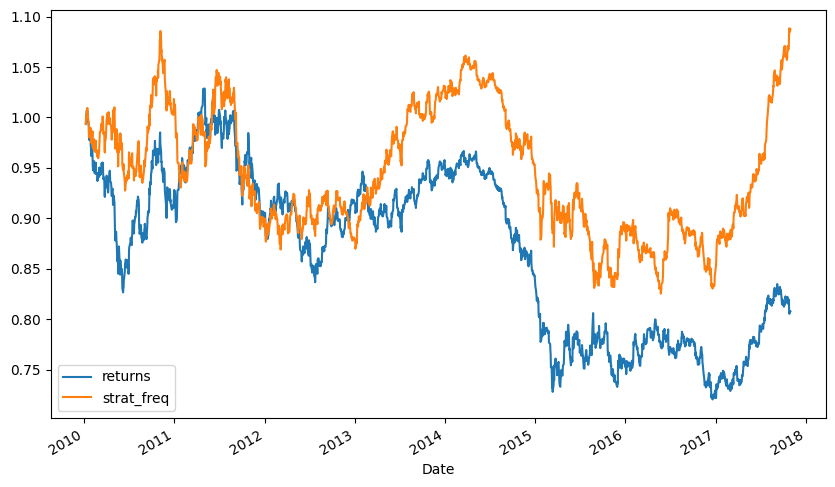

In [66]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_06.png');

## Classification Algorithms

In [67]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [68]:
C = 1

In [69]:
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

In [70]:
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction'])
            for model in models.keys()} 

In [71]:
fit_models(data)

In [72]:
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [73]:
derive_positions(data)

In [74]:
def evaluate_strats(data):  
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model 
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

In [75]:
evaluate_strats(data)

In [76]:
sel.insert(1, 'strat_freq')

In [77]:
data[sel].sum().apply(np.exp)  

returns           0.807938
strat_freq        1.087601
strat_log_reg     1.320000
strat_gauss_nb    1.320000
strat_svm         1.087601
dtype: float64

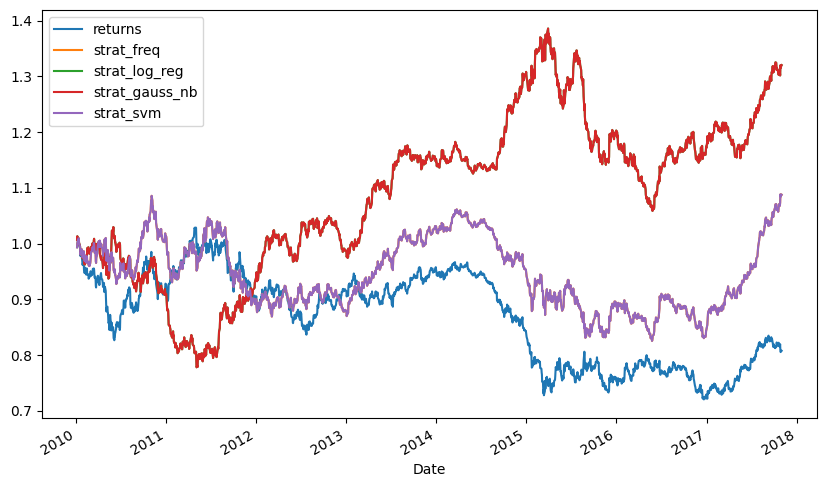

In [78]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_07.png')

In [79]:
data = pd.DataFrame(raw[symbol])

In [80]:
data['returns'] = np.log(data / data.shift(1))

In [81]:
data['direction'] = np.sign(data['returns'])

In [82]:
lags = 5  
create_lags(data)
data.dropna(inplace=True)

In [83]:
create_bins(data)  
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [84]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,1,1,0,1,0
2010-01-13,0,1,1,0,1
2010-01-14,1,0,1,1,0
2010-01-15,0,1,0,1,1
2010-01-19,0,0,1,0,1


In [85]:
data.dropna(inplace=True)

In [86]:
fit_models(data)

In [87]:
derive_positions(data)

In [88]:
evaluate_strats(data)

In [89]:
data[sel].sum().apply(np.exp)

returns           0.802315
strat_log_reg     1.124849
strat_gauss_nb    1.124849
strat_svm         2.650562
dtype: float64

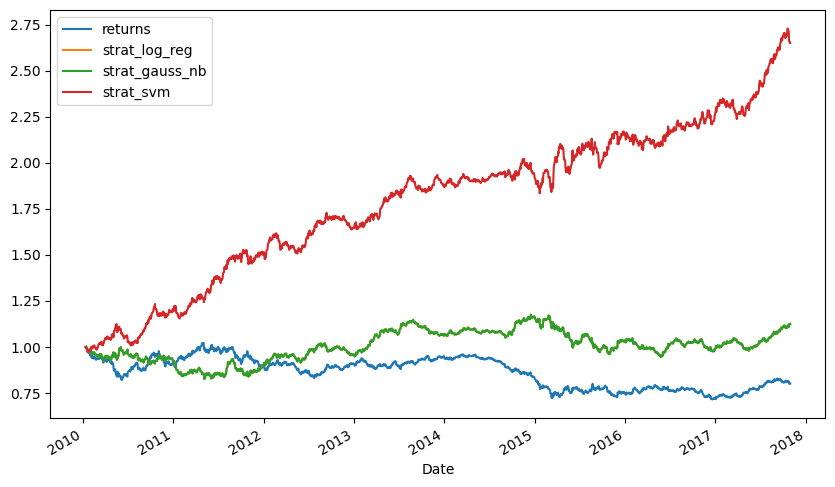

In [90]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_08.png');

In [91]:
mu = data['returns'].mean()  
v = data['returns'].std()  

In [92]:
bins = [mu - v, mu, mu + v]  
bins  

[-0.00613895454184234, -0.00011203142095872083, 0.0059148916999248995]

In [93]:
create_bins(data, bins)

In [94]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-19,0,1,2,1,3


In [95]:
fit_models(data)

In [96]:
derive_positions(data)

In [97]:
evaluate_strats(data)

In [98]:
data[sel].sum().apply(np.exp)

returns           0.802315
strat_log_reg     1.282427
strat_gauss_nb    1.341964
strat_svm         5.877609
dtype: float64

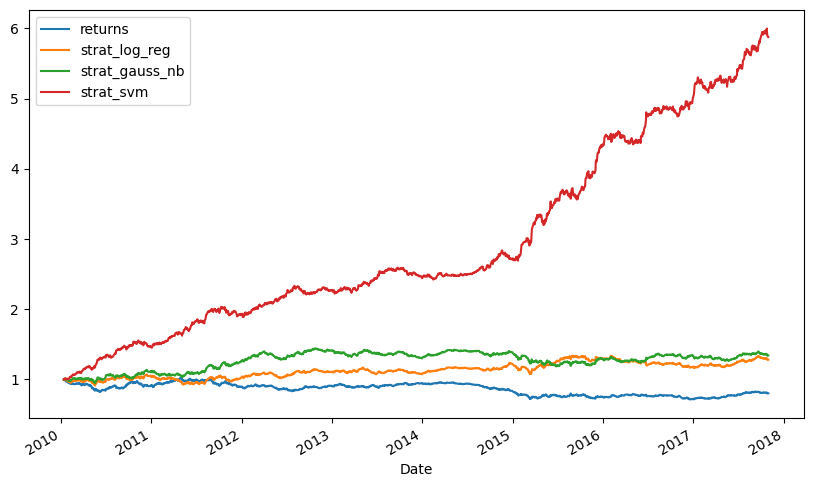

In [99]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_09.png')

### Sequential Train-Test Split

In [100]:
split = int(len(data) * 0.5)

In [101]:
train = data.iloc[:split].copy()  

In [102]:
fit_models(train)  

In [103]:
test = data.iloc[split:].copy()  

In [104]:
derive_positions(test)  

In [105]:
evaluate_strats(test)  

In [106]:
test[sel].sum().apply(np.exp)

returns           0.851979
strat_log_reg     0.943480
strat_gauss_nb    0.911414
strat_svm         0.919531
dtype: float64

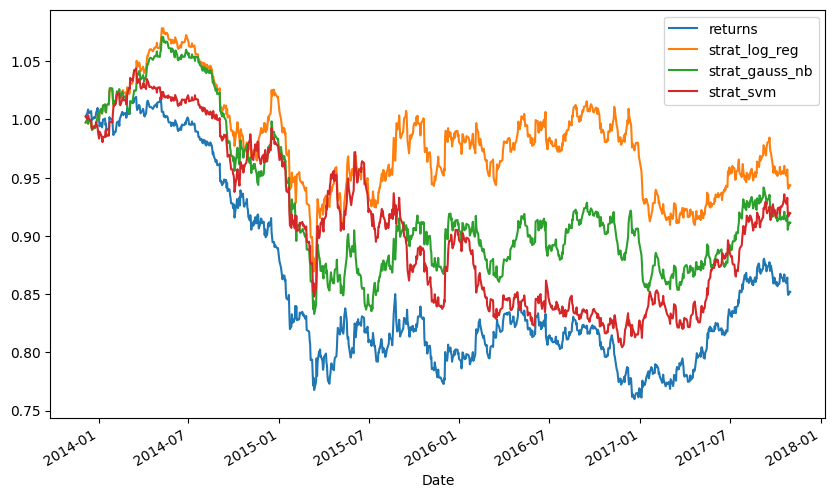

In [107]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_10.png');

### Randomized Train-Test Split

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
train, test = train_test_split(data, test_size=0.5,
                               shuffle=True, random_state=100)

In [110]:
train = train.copy().sort_index()  

In [111]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-20,1,0,1,2,1


In [112]:
test = test.copy().sort_index()  

In [113]:
fit_models(train)

In [114]:
derive_positions(test)

In [115]:
evaluate_strats(test)

In [116]:
test[sel].sum().apply(np.exp)

returns           0.847855
strat_log_reg     0.981150
strat_gauss_nb    1.102309
strat_svm         0.948384
dtype: float64

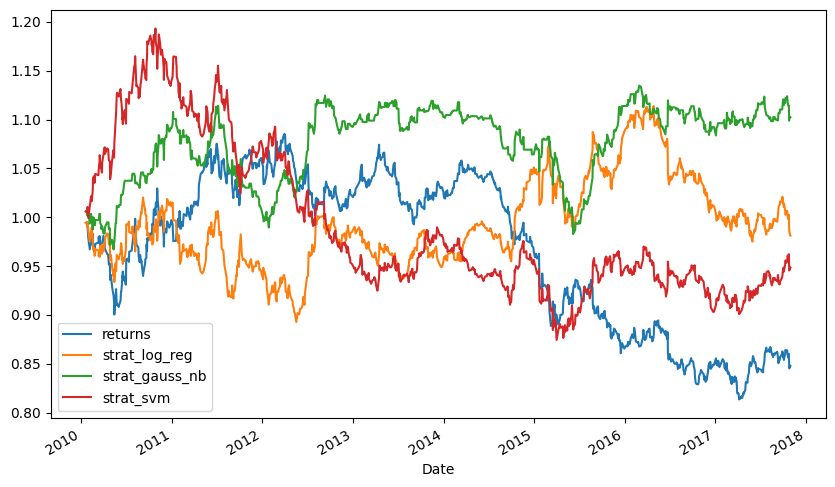

In [117]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_11.png');

## Deep Neural Network

### DNN with scikit-learn

In [118]:
from sklearn.neural_network import MLPClassifier

In [119]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=2 * [250], random_state=1)

In [120]:
%time model.fit(data[cols_bin], data['direction'])

CPU times: user 46.9 s, sys: 1.41 s, total: 48.3 s
Wall time: 6.79 s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [121]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [122]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [123]:
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns          0.802315
strat_dnn_sk    45.430305
dtype: float64

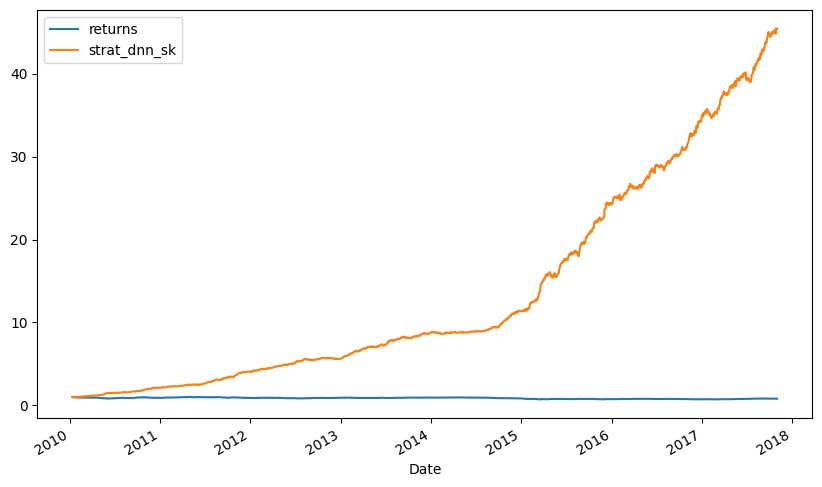

In [124]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_12.png');

In [125]:
train, test = train_test_split(data, test_size=0.5, random_state=100)

In [126]:
train = train.copy().sort_index()

In [127]:
test = test.copy().sort_index()

In [128]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
                     hidden_layer_sizes=3 * [500], random_state=1)  

In [129]:
%time model.fit(train[cols_bin], train['direction'])

CPU times: user 5min 43s, sys: 7.57 s, total: 5min 51s
Wall time: 49.5 s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [130]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [131]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']

In [132]:
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns         0.847855
strat_dnn_sk    0.997007
dtype: float64

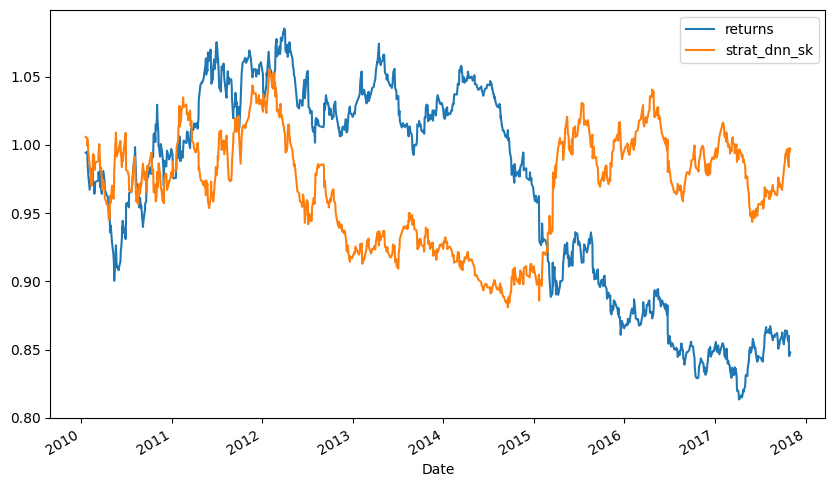

In [133]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_13.png');

### DNN with Keras & TensorFlow Backend

In [134]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

In [135]:
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=lags))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [136]:
data_ = (data - data.mean()) / data.std()
data['direction_'] = np.where(data['direction'] == 1, 1, 0)

In [137]:
model = create_model()

In [138]:
%%time
model.fit(data_[cols], data['direction_'],
          epochs=50, verbose=False)

CPU times: user 1.12 s, sys: 125 ms, total: 1.24 s
Wall time: 976 ms


In [139]:
model.evaluate(data_[cols], data['direction_'])

62/62 [==============================] - 0s 286us/step - loss: 0.6733 - accuracy: 0.5804


[0.6732577085494995, 0.5803662538528442]

In [140]:
pred = np.where(model.predict(data_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

62/62 [==============================] - 0s 227us/step


array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0])

In [141]:
data['pos_dnn_ke'] = np.where(pred > 0, 1, -1)  

In [142]:
data['strat_dnn_ke'] = data['pos_dnn_ke'] * data['returns']

In [143]:
data[['returns', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.802315
strat_dnn_ke    4.389025
dtype: float64

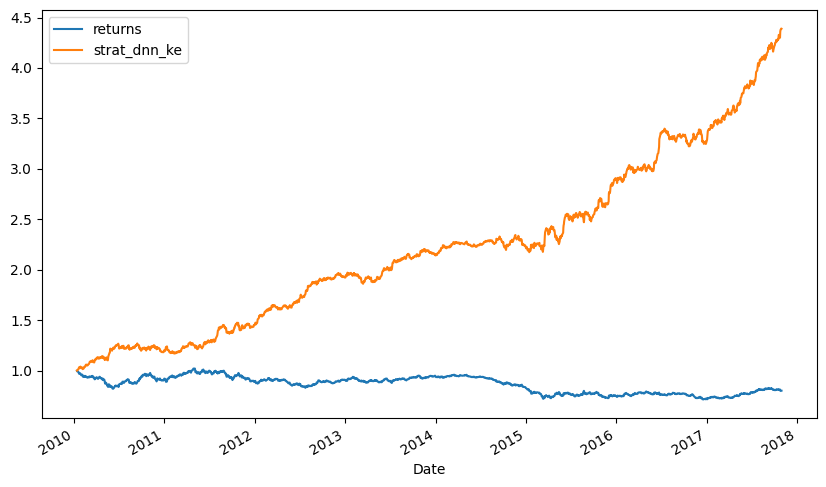

In [144]:
data[['returns', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_14.png');

In [145]:
mu, std = train.mean(), train.std()

In [146]:
train_ = (train - mu) / mu.std()

In [147]:
model = create_model()

In [148]:
train['direction_'] = np.where(train['direction'] > 0, 1, 0)

In [149]:
%%time
model.fit(train_[cols], train['direction_'],
          epochs=50, verbose=False)

CPU times: user 869 ms, sys: 69.9 ms, total: 939 ms
Wall time: 597 ms


In [150]:
test_ = (test - mu) / std

In [151]:
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

In [152]:
model.evaluate(test_[cols], test['direction_'])

31/31 [==============================] - 0s 305us/step - loss: 1.2626 - accuracy: 0.5117


[1.2625534534454346, 0.5116989016532898]

In [153]:
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

31/31 [==============================] - 0s 252us/step


array([1, 1, 0, 0, 1, 0, 1, 0, 1, 0])

In [154]:
test['pos_dnn_ke'] = np.where(pred > 0, 1, -1)

In [155]:
test['strat_dnn_ke'] = test['pos_dnn_ke'] * test['returns']

In [156]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.847855
strat_dnn_sk    0.997007
strat_dnn_ke    1.309935
dtype: float64

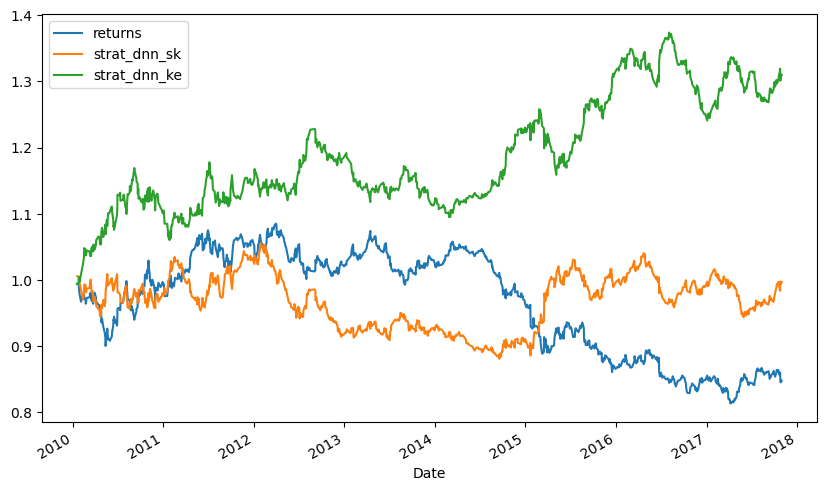

In [157]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_15.png');

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>